In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [3]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

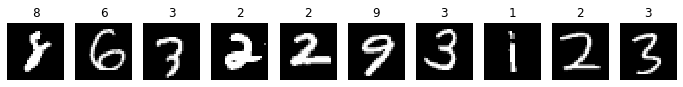

In [4]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

In [5]:
# data from numpy to tensor 
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

train_im = train_images.copy()
test_im = test_images.copy()
train_lab = train_labels.copy()
test_lab = test_labels.copy()

train_im = train_im.reshape(train_im.shape[0], 1, train_im.shape[1], train_im.shape[2])
test_im = test_im.reshape(test_im.shape[0], 1, test_im.shape[1], test_im.shape[2])

train_input = torch.from_numpy(train_im)
test_input = torch.from_numpy(test_im)
train_target = torch.from_numpy(train_lab)
test_target = torch.from_numpy(test_lab)

print(train_input.size(), test_input.size(), train_target.size(), test_target.size())

torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28]) torch.Size([60000]) torch.Size([10000])


We contruct a model that first applies a convolutional filter to the images and then reduce them into a single vector of size 10 corresponding to the class scores (digit 0 to 9). 

Input :&emsp;&emsp; &emsp;&emsp;&emsp;&emsp;&emsp;    60'000 x  1 x 28 x 28 (= images)    <br>
1st convolution :&emsp;&nbsp;&nbsp;&nbsp; 60'000 x 32 x  8 x  8               <br>
2nd convolution :&emsp;&nbsp; 60'000 x 64 x  2 x  2               <br>
view :&emsp;&emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;       60'000 x 256                        <br>
MLP layer 1 :&emsp;&emsp;&emsp;&nbsp;&nbsp;   60'000 x 100                        <br>
MLP output :&emsp;&emsp;&emsp;&nbsp;&nbsp;       60'000 x 10 (= class scores)        <br>

We use ReLu as activation function

In [6]:
# The ConvNet module is a simple network that applies a convolution filter before the multi-layer perceptron
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # Pre-processing with a convolutional filter
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        
        # MLP 1 layer, 100 units : The output of the convolutional layer is reduce into a single vector of size 256 -> 100 -> 10 through the MLP
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 10) # output 10 classes
        
        #Dropout method drop connections between nodes in the MLP during training to reduce training time and avoid over-fitting
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        
        # Pre-processing with a convolutional filter
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
       
        # MLP 1 layer, 100 units
        x = self.dropout(F.relu(self.fc1(x.view(-1, 256))))
        x = self.fc2(x)
        
        return x

In [7]:
# Training 
def train_model(model, train_input, train_target, mini_batch_size): 
        criterion = torch.nn.CrossEntropyLoss()  # Loss criterion = Cross Entropy
        optimizer = optim.SGD(model.parameters(), lr = 1e-3) # Optimizer = SGD
        nb_epochs = 25
        
        for e in range(nb_epochs):
            losses = 0
            for b in range(0, train_input.size(0), mini_batch_size):
                output = model(train_input.narrow(0, b, mini_batch_size)) # prediction
                loss = criterion(output, train_target.narrow(0, b, mini_batch_size)) # computation of the loss
                model.zero_grad()
                loss.backward() # backward pass 
                optimizer.step() # optimizaiton of the weights
                losses += loss.item()
            
            print('Iteration {}, loss = {}'.format(e, losses))

# Computation of errors
def compute_nb_errors(model, data_input, data_target, mini_batch_size):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output, 1)
        for k in range(mini_batch_size):
            if data_target[b + k] != predicted_classes[k]: #if the prediction is not right, increase number of errors
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

In [8]:
mini_batch_size = 500
model = ConvNet()

# Training
train_model(model, train_input, train_target, mini_batch_size)

# Computing number of errors on the test set and train set
nb_train_errors = compute_nb_errors(model, train_input, train_target, mini_batch_size)
nb_test_errors = compute_nb_errors(model, test_input, test_target, mini_batch_size)

# Train and test accuracy
print('train error Net {:0.2f}%'.format(100 - ((100 * nb_train_errors) / train_input.size(0))))
print('test error Net {:0.2f}%'.format(100 - ((100 * nb_test_errors) / test_input.size(0))))

Iteration 0, loss = 172.98556384444237
Iteration 1, loss = 56.58769433200359
Iteration 2, loss = 44.16014987230301
Iteration 3, loss = 37.12584824860096
Iteration 4, loss = 32.75279611349106
Iteration 5, loss = 29.619339153170586
Iteration 6, loss = 26.717351607978344
Iteration 7, loss = 24.655470497906208
Iteration 8, loss = 23.215447276830673
Iteration 9, loss = 22.003466196358204
Iteration 10, loss = 20.612627521157265
Iteration 11, loss = 19.57685873657465
Iteration 12, loss = 18.799755439162254
Iteration 13, loss = 17.841974806040525
Iteration 14, loss = 17.225797899067402
Iteration 15, loss = 16.657754622399807
Iteration 16, loss = 15.931753054261208
Iteration 17, loss = 15.460655692964792
Iteration 18, loss = 15.025718465447426
Iteration 19, loss = 14.693720791488886
Iteration 20, loss = 14.206740740686655
Iteration 21, loss = 13.765820235013962
Iteration 22, loss = 13.584057103842497
Iteration 23, loss = 13.28795762360096
Iteration 24, loss = 12.711608216166496
train error Net 

In [9]:
#Example of prediction on some test images
np.random.seed(12)
a = np.random.randint(1000, size=(12))
output_test = model(test_input[a]).softmax(1)
_, predicted_classe = torch.max(output_test, 1)
print('test target :', test_target[a])
print('test prediction  :', predicted_classe)
b = output_test.detach().numpy()

test target : tensor([4, 7, 2, 5, 9, 0, 6, 1, 8, 4, 2, 4])
test prediction  : tensor([4, 7, 2, 5, 8, 0, 0, 1, 8, 4, 2, 4])


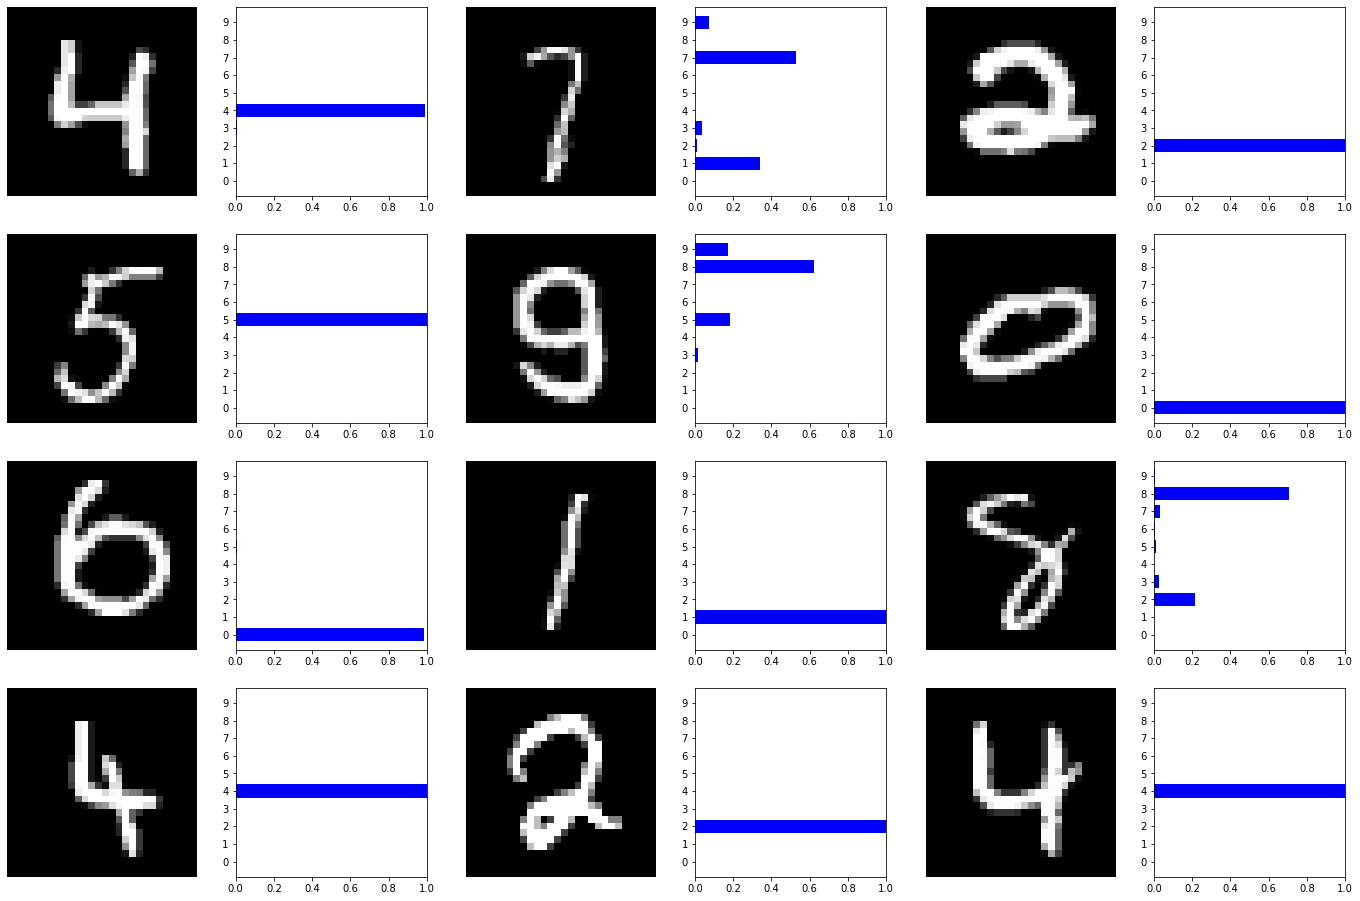

In [10]:
fig, axes = plt.subplots(4, 6, figsize=(24,16))
ax = axes.ravel()

for ind in range(b.shape[0]):
    
    ax[2*ind].imshow(test_input[a[ind],0], cmap='gray')
    ax[2*ind].axis('off')
    
    width = 0.75
    xpos = np.arange(b.shape[1])  # the x locations for the groups
    ax[2*ind+1].barh(xpos, b[ind], width, color="blue")
    ax[2*ind+1].set_yticks(xpos)
    ax[2*ind+1].set_yticklabels(xpos)
    ax[2*ind+1].set_xlim(0,1)

plt.show()